In [318]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import tensorflow as tf
from tensorflow.keras import layers
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


In [3]:
full_df = pd.io.stata.read_stata('data/oreopoulos resume study replication data file.dta')

df = full_df.drop(columns=['interview', 'second_callback'])


In [338]:
for i in range(5):
    tmp = df.where(df["type"] == i)
    curr_res = tmp['callback'].mean()
    print(f"{i}: {curr_res}")

0: 0.1417713165283203
1: 0.10041493922472
2: 0.09311562031507492
3: 0.0811479464173317
4: 0.06004036217927933


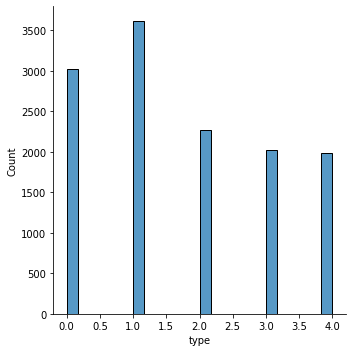

In [252]:
type_dist = sns.displot(df["type"], )
type_dist.savefig("type_dist.png")

firmid                  472.1
additional_credential     0.1
language_skills           0.2
accreditation             0.0
reference                 0.0
                         ... 
indian                    0.1
british                   0.1
pakistani                 0.1
Chn_Cdn                   0.1
same_exp                  0.3
Length: 25, dtype: float64


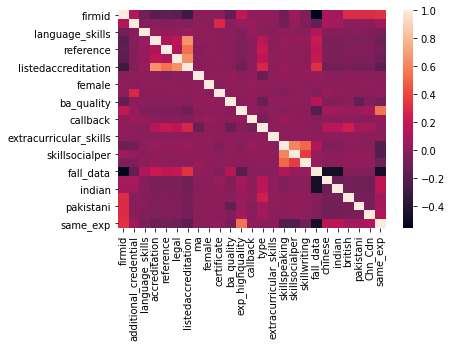

In [254]:
df.fillna(value = df.median(), inplace=True)
cov_t = df.corr()
heatmap_ax = sns.heatmap(cov_t)
heatmap = heatmap_ax.get_figure()
heatmap.savefig("heatmap.png")

print(df.mean())

In [6]:
def run_logit_model(X_train, X_test, y_train, y_test, regularization: float=0.005,
                    validation_split: float=0.15, batch_size: int=128, epochs: int=500):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(1, input_dim=len(X_train.columns),
                                    activation='sigmoid', name='input_layer',
                                    bias_regularizer=tf.keras.regularizers.L2(regularization)))
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_split=validation_split, shuffle=True, verbose=2)
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {loss}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")
    return model

In [8]:
# Data preparation for basic model
y = df.callback
base_features = ['ba_quality', 'exp_highquality', 'female', 'type']
X = df[base_features]
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=0)
base_logit_model = run_logit_model(X_train, X_test, y_train, y_test, regularization=0.15,
                validation_split=0.15, batch_size=320, epochs=20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
28/28 - 2s - loss: 1.6808 - accuracy: 0.2210 - precision_1: 0.0960 - recall_1: 0.8199 - val_loss: 1.6543 - val_accuracy: 0.2594 - val_precision_1: 0.0998 - val_recall_1: 0.7640
Epoch 2/20
28/28 - 0s - loss: 1.6037 - accuracy: 0.2630 - precision_1: 0.0933 - recall_1: 0.7425 - val_loss: 1.5790 - val_accuracy: 0.2735 - val_precision_1: 0.0928 - val_recall_1: 0.6832
Epoch 3/20
28/28 - 0s - loss: 1.5292 - accuracy: 0.3258 - precision_1: 0.0866 - recall_1: 0.6109 - val_loss: 1.5064 - val_accuracy: 0.3458 - val_precision_1: 0.0847 - val_recall_1: 0.5404
Epoch 4/20
28/28 - 0s - loss: 1.4576 - accuracy: 0.3338 - precision_1: 0.0847 - recal

In [290]:
features = ['language_skills', 'accreditation',
            'reference', 'legal', 'listedaccreditation', 'ma', 'female',
            'certificate', 'ba_quality', 'exp_highquality', 'type',
            'extracurricular_skills', 'skillspeaking', 'skillsocialper',
            'skillwriting']
X = df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=0)
full_logit_model = run_logit_model(X_train, X_test, y_train, y_test, epochs=20)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
69/69 - 2s - loss: 8.3847 - accuracy: 0.9011 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - val_loss: 8.0853 - val_accuracy: 0.8961 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 2/20
69/69 - 0s - loss: 7.0501 - accuracy: 0.9011 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - val_loss: 6.6910 - val_accuracy: 0.8961 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 3/20
69/69 - 0s - loss: 5.7420 - accuracy: 0.9011 - precision_15: 0.0000e+00 - recall_15: 0.0000e+00 - val_loss: 5.3176 - val_accuracy: 0.8961 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00
Epoch 4/20
69/69 - 0s 

In [14]:
logit_model = run_logit_model(X_train, X_test, y_train, y_test, epochs=15)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 16        
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
69/69 - 2s - loss: 2.1240 - accuracy: 0.9011 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 1.5114 - val_accuracy: 0.8961 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/15
69/69 - 0s - loss: 0.9494 - accuracy: 0.8800 - precision_7: 0.1021 - recall_7: 0.0277 - val_loss: 0.7168 - val_accuracy: 0.8342 - val_precision_7: 0.1522 - val_recall_7: 0.1304
Epoch 3/15
69/69 - 0s - loss: 0.7063 - accuracy: 0.8463 - precision_7: 0.1148 - recall_7: 0.0831 - val_loss: 0.7007 - val_accuracy: 0.8535 - val_precision_7: 0.1765 - val_recall_7: 0.1118
Epoch 4/15
69/69 - 0s - loss: 0.6886 - accuracy: 0.8497 - precision

In [26]:
# Logistic regression sanity checks
base_arr = np.array([[1, 1, 0, 4]])
base_logit_model.predict(base_arr)
full_arr = np.array([[1,0,0,0,1,1,
                      1, # <- female, play with it
                      1,0,1,0,
                      0, # <- type, this is the feature to play with.
                      70,39,10]])
logit_model.predict(full_arr)

array([[0.5199433]], dtype=float32)

In [291]:
# XGBoost model
def run_gradient_boost_model(X_train, X_test, y_train, y_test, leaves:int=128,
                             rounds:int=1000, early_stop:int=10):
    df_train = lgb.Dataset(X_train, label=y_train)
    df_test = lgb.Dataset(X_test, label=y_test)

    param = {'num_leaves': 128, 'objective': 'binary',
             'metric': 'auc', 'seed': 7}
    print("Training model!")
    model = lgb.train(param, df_train, num_boost_round=1000, valid_sets=[df_test],
                    early_stopping_rounds=10, verbose_eval=False)

    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)
    shap_plot = shap.summary_plot(shap_values, X_test, axis_color="white")
    return model


Training model!
[LightGBM] [Info] Number of positive: 1027, number of negative: 9301
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 10328, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099438 -> initscore=-2.203480
[LightGBM] [Info] Start training from score -2.203480


 98%|===================| 2530/2582 [00:12<00:00]        

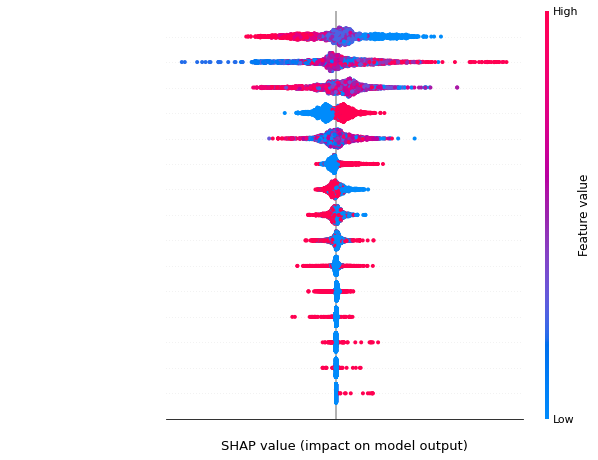

In [309]:
gradient_boost_model = run_gradient_boost_model(X_train, X_test, y_train, y_test)
y_pred_arr = gradient_boost_model.predict(X_test)
y_pred = pd.Series(y_pred_arr)

In [319]:
def custom_evaluate_model(y_pred, y_test, threshold):
    acc = 0
    true_positive = 0
    false_positive = 0
    for i in range(len(y_pred)):
        pred = 0 if y_pred.values[i] < threshold else 1
        real = y_test.values[i]
        if pred == real:
            acc = acc + 1
        if pred == 1:
            if real==1:
                true_positive = true_positive + 1
            else:
                false_positive = false_positive + 1
    accuracy = acc/len(y_pred)
    recall = true_positive /(0.00001+sum(y_test))
    precision = true_positive / (true_positive + false_positive + 0.00001)
    return accuracy, precision, recall

In [320]:
custom_evaluate_model(y_pred, y_test, 0.2)

(0.8446940356312935, 0.22900762484703724, 0.23166022271582154)

In [ ]:
# Boost sanity check.
full_arr = np.array([[1,0,0,0,1,1,
                      1, # <- female, play with it
                      1,0,1,0,
                      0, # <- type, this is the feature to play with.
                      76,40,30]])
gradient_boost_model.predict(full_arr)

In [80]:
def run_dnn_model(X_train, X_test, y_train, y_test, regularization: float=0.005,
                    validation_split: float=0.15, batch_size: int=128, epochs: int=500):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(45, input_dim=len(X_train.columns),
                            activation='tanh', name='input_layer'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(135, activation='sigmoid', name='hidden_layer1',
                            bias_regularizer=tf.keras.regularizers.L2(regularization)))
    model.add(layers.Dense(30, activation='tanh', name='hidden_layer2'))
    model.add(layers.Dense(1, activation='sigmoid', name='final_layer'))

    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    print(model.summary())
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
              validation_split=validation_split, shuffle=True, verbose=2)
    loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(f"Loss: {loss}\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}")
    return model


In [82]:
dnn_model = run_dnn_model(X_train, X_test, y_train, y_test, epochs=2500, batch_size=120,
                          regularization=0.015)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 45)                720       
_________________________________________________________________
dropout_5 (Dropout)          (None, 45)                0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 135)               6210      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 30)                4080      
_________________________________________________________________
final_layer (Dense)          (None, 1)                 31        
Total params: 11,041
Trainable params: 11,041
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2500
74/74 - 2s - loss: 0.3538 - accuracy: 0.8803 - precision_13: 0.1097 - recall_13: 0.0300 - val_los

In [334]:
dnn_model_predictions = dnn_model.predict(X_test)
pred_arr = [i[0] for i in dnn_model_predictions]
dnn_pred = pd.Series(pred_arr)
custom_evaluate_model(dnn_pred, y_test, 0.2)

(0.8702556158017041, 0.23239434983138382, 0.12741312249370185)

In [327]:
# DNN sanity check
full_arr = np.array([[1,1,0,0,1,1,
                      1, # <- female, play with it
                      0,1,1,
                      0,# <- type, this is the feature to play with.
                      0,91,25,9]])
dnn_model.predict(full_arr)

array([[0.82149315]], dtype=float32)

In [219]:
# Discrimination detection algorithm

def actual_justice_maker(model, data: pd.DataFrame, feature: str):
    feature_dtype = data[feature].dtype
    if not (feature_dtype == int or feature == bool):
        raise ValueError(f"Expected input feature of type int or bool but got {feature_dtype} for feature: {feature}")
    list_of_existing_values = data[feature].unique()
    list_of_possible_values = list_of_existing_values if len(list_of_existing_values) > 1 else [0,1]
    delta = 0
    for vector in data.iterrows():
        vector_results = []
        for value in list_of_possible_values:
            mutable_vector = vector[1].__deepcopy__()
            mutable_vector[feature] = value
            v = [i for i in mutable_vector.values]
            p = model.predict(np.array([v]))
            vector_results.append(p)
        local_delta = min(vector_results) - max(vector_results)
        delta = delta + local_delta
    return (feature, delta/len(data))

def calculate_score(results):
    s = 0
    for feature, d in results:
        s = s + d
    s = s / len(results)
    s = sigmoid(s)
    return s

def sigmoid(x):
    return (1 / (1+(100*np.e**(9*x))))

def justice_maker(model, data:pd.DataFrame, list_of_features, verbose=0):
    results = []
    for feature in list_of_features:
        result = actual_justice_maker(model, data, feature)
        results.append(result)
    score = calculate_score(results)
    if verbose==1:
        nice_results = [{r[0]: sigmoid(float(r[1]))} for r in results]
        return float(score), nice_results
    return float(score)

In [317]:
full_arr = np.array([[1,1,0,0,1,1,
                      1, # <- female, play with it
                      0,1,1,
                      0,# <- type, this is the feature to play with.
                      0,91,25,9]])
full_arr1 = [1,1,0,0,1,1,1,0,
             1,1,0,0,91,25,9]

full_arr2 = [1,1,0,0,1,1,0,0,
             1,1,1,0,91,25,9]

full_arr3 = [1,1,0,0,1,1,1,0,
             1,1,2,0,91,25,9]

full_arr4 = [1,1,0,0,1,1,1,0,
             1,1,3,0,91,25,9]

full_arr5 = [1,1,0,0,1,1,1,0,
             1,1,4,0,91,25,9]

sample_df = pd.DataFrame(data=[full_arr1, full_arr2, full_arr3, full_arr4, full_arr5],
                         columns=features)


In [224]:
logit_results = justice_maker(model=full_logit_model,
              data=sample_df,
              list_of_features=["type", "female"],
              verbose=1)
gboosting_results = justice_maker(model=gradient_boost_model,
              data=sample_df,
              list_of_features=["type", "female"],
              verbose=1)
dnn_results = justice_maker(model=dnn_model,
              data=sample_df,
              list_of_features=["type", "female"],
              verbose=1)

print(f"logit: {logit_results}\nlgb: {gboosting_results}\ndnn: {dnn_results}")



logit: (0.00990099087357521, [{'type': 0.00990099102815311}, {'female': 0.009900990442908054}])
lgb: (0.03144273353872806, [{'type': 0.07445438431239326}, {'female': 0.012931380171158429}])
dnn: (0.4491825997829437, [{'type': 0.9032215337507173}, {'female': 0.06651543727353065}])


In [244]:
graph_df = pd.DataFrame(columns=['Model', 'Metric', 'Value'],
                        data=[['Logit','Type',logit_results[1][0]['type']],
                              ["Logit", "Female",logit_results[1][1]['female']],
                              ["Logit", "Score", logit_results[0]],
                              ['Gradient Boosting','Type', gboosting_results[1][0]['type']],
                              ["Gradient Boosting", "Female",gboosting_results[1][1]['female']],
                              ["Gradient Boosting", "Score", gboosting_results[0]],
                              ['DNN','Type', dnn_results[1][0]['type']],
                              ["DNN", "Female",dnn_results[1][1]['female']],
                              ["DNN", "Score", dnn_results[0]]])

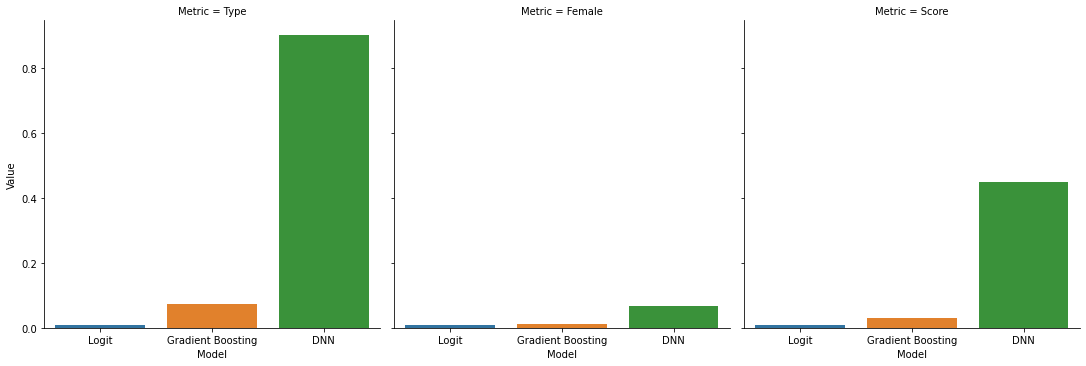

In [250]:
p = sns.catplot(x="Model", y="Value", data=graph_df,
            kind="bar", col="Metric")
p.savefig("result_sum.png")


